In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
 
# load dataset
dataset = read_csv('/Users/sakshikarnawat/Desktop/valet-tool/parse_tactics/normalized_tva_server_1_tactic_1_train.csv')
dataset= dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/sakshikarnawat/Desktop/valet-tool/parse_tactics/normalized_tva_server_1_tactic_1_test.csv')
validation= validation.drop(columns=["timestamp","ping_timestamp","ping_success"])
values_validation = validation.values


   time_since_last_recording   latency      cost  reliability  \
0                   0.000000  0.015102  0.193359            1   
1                   0.016458  0.015117  0.310547            1   
2                   0.003947  0.015297  0.169922            1   
3                   0.013916  0.014803  0.191406            1   
4                   0.016191  0.014817  0.167969            1   

   time_since_last_ping  ping_time  
0                   0.0   0.000000  
1                   0.0   0.000000  
2                   0.0   0.000000  
3                   0.0   0.000000  
4                   0.0   0.491071  


In [4]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,10,11]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,7,8]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var2(t)  \
1        0.0   0.015102   0.193359        1.0        0.0        0.0  0.015117   

    var3(t)  var4(t)  
1  0.310547      1.0  


In [5]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12156, 1, 6) (12156, 3) (2604, 1, 6) (2604, 3)


Epoch 1/20
12156/12156 [==============================] - 1s 103us/step - loss: 0.0231
Epoch 2/20
12156/12156 [==============================] - 1s 77us/step - loss: 8.6049e-05
Epoch 3/20
12156/12156 [==============================] - 1s 70us/step - loss: 7.4210e-05: 0s - loss: 7.342
Epoch 4/20
12156/12156 [==============================] - 1s 42us/step - loss: 7.2401e-05
Epoch 5/20
12156/12156 [==============================] - 0s 34us/step - loss: 7.0663e-05
Epoch 6/20
12156/12156 [==============================] - 1s 43us/step - loss: 6.9901e-05: 0s - loss: 
Epoch 7/20
12156/12156 [==============================] - 1s 44us/step - loss: 6.9680e-05
Epoch 8/20
12156/12156 [==============================] - 1s 60us/step - loss: 6.9086e-05
Epoch 9/20
12156/12156 [==============================] - 0s 39us/step - loss: 6.8652e-05
Epoch 10/20
12156/12156 [==============================] - 1s 42us/step - loss: 6.8614e-05
Epoch 11/20
12156/12156 [==============================] - 0s 35us/step

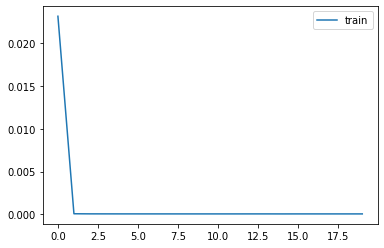

In [6]:
## Run this cell for MLP , else Run the next cell for LSTM

# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
X = train_X.reshape((train_X.shape[0], n_input))

# define MLP model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')
history= model.fit(X, train_y, epochs=20, verbose=1)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [7]:
### Doing the same process for testing dataset

test_dataset = read_csv('/Users/sakshikarnawat/Desktop/valet-tool/parse_tactics/normalized_tva_server_1_tactic_1_validation.csv')
test_dataset= test_dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,10,11]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))


In [8]:
## Feeding the test dataset for predictions
import pandas as pd

## For MLP use below line only
yhat = model.predict(testset_X)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.01667418 0.17202792 0.99934816]
 [0.01651097 0.17308882 0.9993767 ]
 [0.01659112 0.17247385 0.9993565 ]
 ...
 [0.01629247 0.17568257 0.9996975 ]
 [0.01642333 0.1720694  1.0001742 ]
 [0.01645025 0.17083171 1.0001988 ]]


In [9]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [10]:
import numpy as np
result.head(10)
# result.to_csv('/Users/manali/Desktop/PingPredictions/predictions_MLP_server_3_tactic_1_Normalized.csv', sep=',', index=0)

,time_since_last_recording,latency,cost,reliability,time_since_last_ping,ping_time,predicted_Latency,predicted_Cost,predicted_Reliability
0,0.010972,0.017155,0.160156,1,0.006864,0.094776,0.016674,0.172028,1.0
1,0.004683,0.014948,0.167969,1,0.011622,0.094776,0.016511,0.173089,1.0
2,0.000736,0.015292,0.164062,1,0.000272,0.095119,0.016591,0.172474,1.0
3,0.007895,0.016283,0.169922,1,0.003058,0.094886,0.016630,0.173693,1.0
4,0.000000,0.015571,0.173828,1,0.003058,0.094886,0.016522,0.174308,1.0
5,0.011440,0.015474,0.171875,1,0.001699,0.094592,0.016665,0.173952,1.0
6,0.005954,0.016747,0.175781,1,0.001223,0.094447,0.016607,0.174892,1.0
7,0.007560,0.015070,0.162109,1,0.003874,0.094667,0.016636,0.172090,1.0
8,0.001673,0.014855,0.164062,1,0.001087,0.095725,0.016592,0.172343,1.0
9,0.003546,0.016296,0.167969,1,0.004757,0.095725,0.016578,0.173258,1.0


In [11]:
print(testset_y)

[[0.0149483  0.16796875 1.        ]
 [0.01529248 0.1640625  1.        ]
 [0.0162831  0.16992187 1.        ]
 ...
 [0.01635488 0.1796875  1.        ]
 [0.01666088 0.17382812 1.        ]
 [0.01505033 0.16601562 1.        ]]


In [12]:
## Finding the root mean squared error of the model

rmse = sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: ' , rmse)

Test RMSE:  0.04450584864832884


In [13]:
mse = mean_squared_error(yhat, testset_y)
print('Test MSE: ',  mse)

Test MSE:  0.0019807705639079544


In [14]:
mae = mean_absolute_error(yhat, testset_y)
print('Test MAE: ',  mae)

Test MAE:  0.0068792368619197955
